# The zfit package

Currently, the functionality of the zfit package is two-fold: design a high-level API to manage model building, fitting and generation, and implement this API using the `tensorflow` backend.

The final goal is to be able to, given a PDF model `pdf`, a dataset `data`, and a list of `params` to minimize, perform minimization tasks such as

```python
from zfit.core.minimizer import MinuitMinimizer

nll = zfit.unbinned_nll(pdf, data, norm_range=(-10, 10))
minimizer = MinuitMinimizer(nll)
minimizer.minimize(params)
minimizer.hesse(params)
minimizer.error(params)
result = minimizer.get_state()
```

and generation in a very simple way

```python
sample = pdf.sample(n_draws=int(1e7), limits=(-10, 10))
```

## API

The main concepts in the API are
  - Parameters
  - PDFs (for the time being, let's consider scalar functions as unnormalized PDFs)
  - Minimizers
  
In the following, we informally outline the basics of each of these objects, but we will not go into some of the more nitty-gritty API details.


### Parameters

Parameters are named quantities to be optimized in the minimization problems we are trying to solve.
Classes implementing parameters contain the value of the parameter, its limits, whether it's fixed or not, and eventually symmetric and asymmetric errors (**Jonas, is this true?**).


A *Parameter* initialization **MUST** contain its name and its initial value, and **MAY** include its lower and upper limits.

One can access the parameter information through the following properties (names are self explanatory):
  - Values are `init_value` are `fitted_value`.
  - Name is accessed through `name`.
  - Errors are `error`, `upper_error` and `lower_error`, and raise an error if one tries to access them without having performed a minimization first.
  
Additionally, the parameter can be fixed/unfixed using the `set_fixed` method, and the current status can be accessed through the `is_fixed` property (**Jonas, this is not implemented right? I see something about step size but I think it's not the way it should be done**?).



### PDFs

PDF objects are normalized distributions, typically as a function of several parameters.
A very important concept is the *normalization range*, which is mandatory in most operations involving PDFs.

*Note*: details on how to compose and create your own PDFs, implement integrals, etc, belong to the implementation and will be discussed later.

PDF objects **MUST** be initialized giving their named parameters, and **MAY** also have a name. For example:

```python
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, name="My Gaussian")
```

The main methods of the PDF are then

- Getting the probability through the `probs` method, which **MUST** be called with a data array `x` and a normalization range `norm_range` as inputs. For example:

    ```
    # Get the probabilities of some random generated events
    probs = gauss.prob(x=np.random.random(10), norm_range=(-30., 30))
    ```

- Getting the value of its integral in some given `limits`. While the `norm_range` is also mandatory here, it may be requested that this integral is calculated over the unnormalized PDF by setting it to `False`:

    ```python
    # Calculate the integral between -5 and 3 over the PDF normalized between -30 and 30
    integral_norm = gauss.integrate(limits=(-5, 3), norm_range=(-30., 30))
    # Calculate the unnormalized integral 
    integral_unnorm = gauss.integrate(limits=(-5, 3), norm_range=False)
    ```

- Sampling from the PDF is done through the `sample` method, which **MUST** include the number of events `n_draws` as well as the limits from which to draw (`limits`):

    ```python
    # Draw 1000 samples within (-10, 10)
    sample = gauss.sample(n_draws=1000, limits=(-10, 10))
    ```
    
Additionally, extended PDFs, which will result in anything using a `norm_range` to not return the probability but the number probability (the function will be normalized to this yield instead of 1 inside the `norm_range`), can be created through the `set_yield` method, which **MUST** get a parameter as input:

```python
yield1 = Parameter("yield1", 100, 0, 1000)
gauss.set_yield(yield1)
# This integral yields approx 100
integral_extended = gauss.integrate(limits=(-10, 10), norm_range=(-10, 10))
```
    
The `is_extended` property can be then used to check whether a PDF is extended or not.

Loss functions can then be build using `pdf.prob`, following a common interface, in which the model, the dataset and the normalization range **MUST** be given, and where parameter constraints in form of a dictionary `{param: constraint}` **MAY** be given.
As an example for unbinned NLL (but it's the same for binned NLL, $\chi^2$, etc), one would write

```python
my_loss = zfit.unbinned_nll(gauss,
                            data,
                            norm_range=(-10, 10),
                            constraints={})
```

### Minimizers

Minimizer objects are key to provide a coherent fitting API.
They are tied to a loss function and they keep an internal state that can be queried at any moment.

In their initialization, the loss function **MUST** be given. Additionally, the `params` to minimize, the `tolerance`, its `name`, as well as any other arguments needed to configure a particular algorithm **MAY** be given.

The API **REQUIRES** to implement the following methods:
- `minimize(params)`, which returns an `int` with the status. (**JONAS, I see in `core/minimizer.py` that `minimize` doesn't accept params?**).
- `step(params)`, which performs only one step of the minimization procedure. If not applicable, this returns `NotImplementedError`.
- `hesse(params)`, which calculates the Hessian.
- `error(params)`, which calculates the two-sided error. This typically complicated function can be configured with `set_error_options`. Additionally, several methods for calculating this error can be implemented in a given minimizer, and the `set_error_method` method can be used to set the one called by `error`.
- `get_state(copy=True)`, which returns the internal state of the minimizer, *ie*, the parameters, their errors, etc. The optional `copy` parameters controls whether a copy of the internal state (which would be the equivalent of a fit result) is returned, or just a view (reference) of it. 

## Implementation

zfit implements the above API in pure python based on the `tensorflow` framework.

Feature-wise, it adds the capability of building complex models and implementing your own PDFs, some useful functions to make its usage easy, and the possibility of running in a non-eager, advanced mode that allows to take advantage of `tensorflow` graphs.

In addition, it aims to implement a large library of distributions wrapping `tensorflow.distributions` plus the addition of specific HEP ones (not only normalized distributions, but also functions such as spin factors or Blatt-Weisskopf barrier factors), and a complete set of minimizers (currently Minuit, `scipy.optimize` and `tensorflow` optimizers).

As a general idea, context managers will be also implemented wherever there are repetitive parameters to be used (for example, setting normalization ranges) to allow for cleaner code.


Now we'll walk through some simple examples to showcase how zfit is implemented and how to use it in a practical way.

*Note*: We will run in advanced mode (that is, no eager execution, and thus DAG all `tensorflow` objects are DAGs) to illustrate how `tensorflow` is leveraged behind the scenes.
When running in "normal" mode, all these complications (such as the use of sessions and delayed execution) will not be there, thus resulting in simpler code. A context manager will be provided to switch to non-eager execution on the fly.


In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import zfit

print("TensorFlow version:", tf.__version__)
print("Executing eagerly:", tf.executing_eagerly())

/Users/albert/.virtualenvs/zfit-qokI31rn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow version: 1.10.1
Executing eagerly: False


To start off, let's create a few datasets to play with (*note*: no data helpers have been implemented yet, so it's necessary to use tensorflow directly).

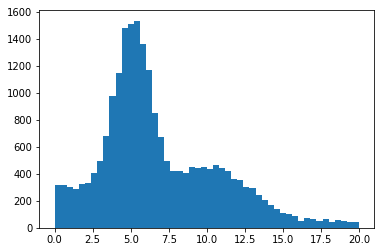

In [2]:
gauss_at_five = np.random.normal(5.1, 1.2, size=10000)
gauss_at_ten = np.random.normal(10.4, 2.3, size=5000)
exp = np.random.exponential(10, size=8000)
_ = plt.hist(np.concatenate([exp,gauss_at_five,gauss_at_ten]),
             bins=50,
             range=(0, 20))

In [3]:
ds_gauss_at_five = tf.convert_to_tensor(gauss_at_five)
ds_gauss_at_ten = tf.convert_to_tensor(gauss_at_ten)
ds_exp = tf.convert_to_tensor(exp)

Now we can try to fit one of the Gaussians.
To do that, we need to create the parameters, instantiate a PDF and run the fitting procedure.

In [4]:
# This shortcut function will be available in zfit, but here
# we use the core one to highlight the use of tensorflow graphs
def api_unbinned_nll(pdf, data, norm_range):
    return zfit.core.loss.unbinned_nll(pdf.prob(data, norm_range=norm_range))

mu1 = zfit.FitParameter("mu", 5.0, 0., 10)
sigma1 = zfit.FitParameter("sigma", 1, 0.1, 5.)
gauss1 = zfit.pdf.Gauss(mu=mu1, sigma=sigma1)

nll1 = api_unbinned_nll(gauss1, ds_gauss_at_five, (0, 20))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
from zfit.minimize import MinuitMinimizer

minimizer = MinuitMinimizer(nll1)
# Prepare tensorflow, this will be removed in the future
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    _ = minimizer.minimize(sess=sess)
    _ = minimizer.hesse(sess=sess)
    _ = minimizer.error(sess=sess)
    
state = minimizer.get_state()
print(state)

/Users/albert/Arxiu/Fisica/LHCb/Projectes/zfit/zfit/zfit/minimizers/minimizer_minuit.py:54: InitialParamWarning: errordef is not given. Default to 1.
  **error_limit_kwargs)


FCN = 15876.374294859168 
 TOTAL NCALL = 65 
 NCALLS = 63 
 
 
 EDM = 0.016735406494794127 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Variable:0,5.11246,0.0168953,,,0,10,No
1,Variable_1:0,1.18336,0.0121354,,,0.1,5,No


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Variable:0,5.11246,0.00118433,,,0,10,No
1,Variable_1:0,1.18336,2.70514,,,0.1,5,No


+,Variable:0,Variable_1:0
Variable:0,1.00,1.00
Variable_1:0,1.00,1.00


RuntimeError: Function mimimum is not valid. Make sure migrad converge first

In [6]:
state.get_parameters()

NameError: name 'state' is not defined

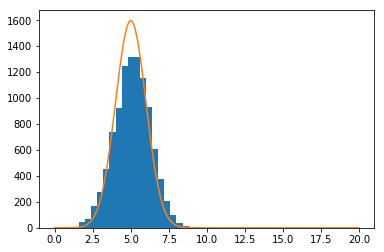

In [7]:
n_bins = 50
range_ = (0, 20)
_ = plt.hist(gauss_at_five, bins=n_bins, range=range_)
x = np.linspace(*range_, num=1000)
with tf.Session() as sess:
    sess.run(init)
    pdf = sess.run(gauss1.prob(x, norm_range=range_))
_ = plt.plot(x, gauss_at_five.shape[0]/n_bins*20.*pdf)